In [58]:
from nufeb_tools import utils,plot
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist,squareform
from scipy.spatial import KDTree
from scipy.spatial import Voronoi, voronoi_plot_2d
import skgeom as sg
from tqdm import tqdm

In [87]:
low = utils.get_data(directory= r'D:\runs\Run_50_50_10_1_2021-07-27')
med = utils.get_data(directory= r'D:\runs\Run_50_50_45_1_2021-07-27')
high = utils.get_data(directory= r'D:\runs\Run_50_50_100_1_2021-07-27')

In [88]:
_ = [x.count_colony_area(35000) for x in [low, med, high]]

Assigning ancestry: 100%|██████████| 350/350 [02:13<00:00,  2.63it/s]


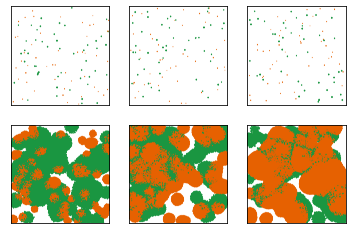

In [89]:
f,axes = plt.subplots(nrows=2,ncols=3)
for ax, x in zip(axes.ravel()[:3],[low,med,high]):
    plot.colony(x,0,by='Species',ax=ax)
for ax, x in zip(axes.ravel()[3:],[low,med,high]):
    plot.colony(x,35000,by='Species',ax=ax)
plt.show()
f.tight_layout()

In [94]:
def fitness_metrics(obj):
    df = obj.colonies.copy()
    # calculate voronoi area
    # calculate voronoi area
    dfs = list()
    for type_ in df.type.unique():
        IDs = df[(df.Timestep ==0) & (df.type == type_)][['mother_cell','type']]
        points = df[(df.Timestep ==0) & (df.type == type_)][['x','y']].values
        vor = Voronoi(points)
        areas = [abs(float(sg.Polygon(vor.vertices[vor.regions[i]]).area())) for i in range(len(vor.regions))]
        IDs['Voronoi Area'] = areas[1:]
        dfs.append(IDs)
    metrics = pd.concat(dfs)

    # total biomass per colony
    biomasses = df[df.Timestep==35000].groupby('mother_cell').sum().reset_index()[['mother_cell','biomass']]
    biomasses.columns=['mother_cell','total biomass']

    # Calculate nearest neighbors
    df3 = df[df.Timestep == 0]
    arr1 = df3[df3.type==1][['x','y','z']].to_numpy()
    tree1 = KDTree(arr1)
    d1, i1 = tree1.query(df3[['x','y','z']].to_numpy(), k=2)
    arr2 = df3[df3.type==2][['x','y','z']].to_numpy()
    tree2 = KDTree(arr2)
    d2, i2 = tree2.query(df3[['x','y','z']].to_numpy(), k=2)
    idx1 =df3.index
    n1 = list()
    n2 = list()
    for i in range(len(d1)):
        if d1[i,0]==0:
            n1.append(d1[i,1])
        else:
            n1.append(d1[i,0])
    for i in range(len(d2)):
        if d2[i,0]==0:
            n2.append(d2[i,1])
        else:
            n2.append(d2[i,0])
    df3['Nearest1']=n1
    df3['Nearest2']=n2
    df3 = df3[['mother_cell','Nearest1','Nearest2']]
    # calculate sum of inverse neighbor distance
    inv1 = list()
    for i in df[df.Timestep == 0][['x','y','z']].to_numpy():
        d1, i1 = tree1.query(i,k=2)
        if d1[0]==0:
            inv1.append(np.sum(1/d1[1]))
        else:
            inv1.append(np.sum(1/d1[0]))
    inv2 = list()
    inv3 = list()
    for i in df[df.Timestep == 0][['x','y','z']].to_numpy():
        d2, i2 = tree2.query(i,k=2)
        if d2[0]==0:
            inv2.append(np.sum(1/d2[1]))
        else:
            inv2.append(np.sum(1/d2[0]))
    # Calculate log inverse squared neighbor distance
    log_inv1 = list()
    for i in df[df.Timestep == 0][['x','y','z']].to_numpy():
        d1, i1 = tree1.query(i,k=2)
        if d1[0]==0:
            log_inv1.append(np.log(np.sum(1/(d1[1]**2))))
        else:
            log_inv1.append(np.log(np.sum(1/(d1[0]**2))))
    log_inv2 = list()
    for i in df[df.Timestep == 0][['x','y','z']].to_numpy():
        d2, i2 = tree2.query(i,k=2)
        if d2[0]==0:
            log_inv2.append(np.log(np.sum(1/(d2[1]**2))))
        else:
            log_inv2.append(np.log(np.sum(1/(d2[0]**2))))

    df3['Inv1']=inv1
    df3['Inv2']=inv2
    df3['Log Inv1']=log_inv1
    df3['Log Inv2']=log_inv2
    colony_area = df[df.Timestep==35000][['mother_cell','Colony Area']].drop_duplicates()

    #df[df.Timestep==0]
    metrics = metrics.merge(biomasses,on='mother_cell')#.groupby('mother_cell').max().reset_index()
    metrics = metrics.merge(df3,on='mother_cell')
    metrics = metrics.merge(colony_area,on='mother_cell')
    metrics
    return metrics
metrics = fitness_metrics(high)

<ipython-input-94-0fee1be4ce9d>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Nearest1']=n1
<ipython-input-94-0fee1be4ce9d>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Nearest2']=n2


In [134]:
metric2 = metrics[metrics.type==2]
import statsmodels.api as sm
metric_list = ['Colony Area','Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2']
y = metric2['total biomass']
def get_stats():
    x = metric2[metric_list]
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.366e+29
Date:                Fri, 10 Sep 2021   Prob (F-statistic):                        0.00
Time:                        16:26:35   Log-Likelihood:                          948.81
No. Observations:                  50   AIC:                                     -1882.
Df Residuals:                      42   BIC:                                     -1866.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

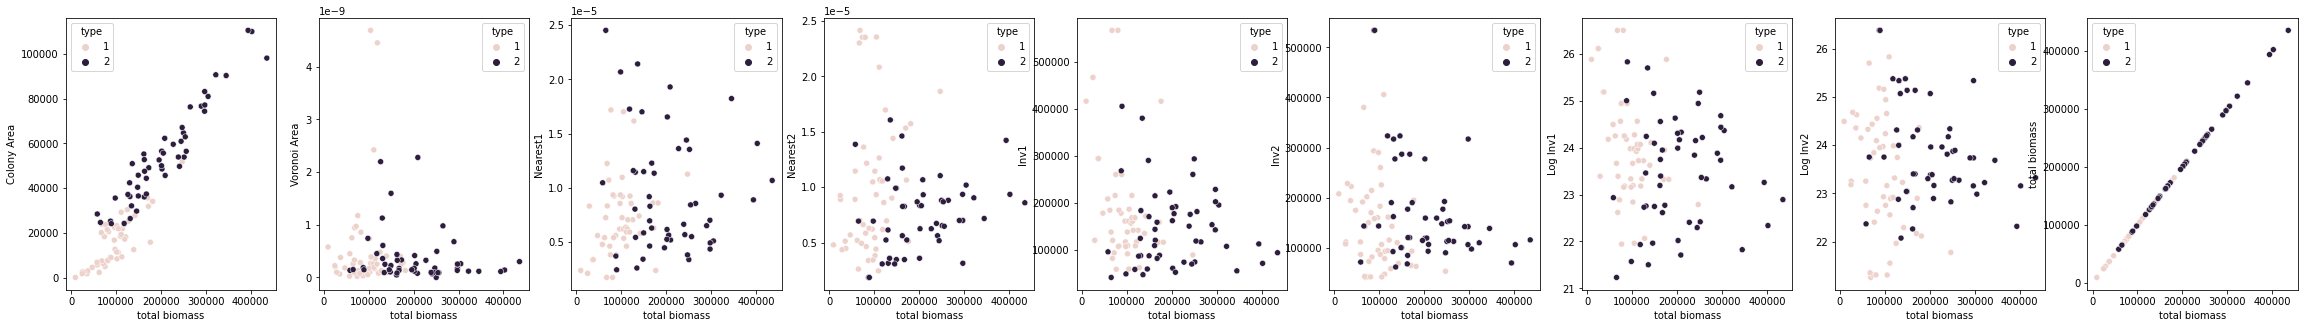

In [117]:

f, axes = plt.subplots(ncols=len(metric_list),figsize=(40,5))
for met,ax in zip(metric_list,axes.ravel()):

   sns.scatterplot(x='total biomass',y=met,hue='type',data=metrics,ax=ax)

#for ax in axes.ravel():
   # ax.set_xscale('log')
   # ax.set_yscale('log')


In [66]:
metric2.reset_index(drop=True,inplace=True)

In [98]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [175]:
scaler = StandardScaler()
metric_list = ['Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2']
y = metric2['total biomass']
def get_stats():
    x = metric2[metric_list]
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

x = metric2.loc[:, metric_list].values# Separating out the target
y = metric2.loc[:,['total biomass']].values# Standardizing the features
X = scaler.fit_transform(x,y)

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.891
Model:                            OLS   Adj. R-squared (uncentered):              0.873
Method:                 Least Squares   F-statistic:                              50.27
Date:                Fri, 10 Sep 2021   Prob (F-statistic):                    1.17e-18
Time:                        17:16:35   Log-Likelihood:                         -631.47
No. Observations:                  50   AIC:                                      1277.
Df Residuals:                      43   BIC:                                      1290.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [193]:
metric_list = ['Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2']
to_scale = ['Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2','total biomass']
scaled_df = metrics.copy()
scaled_df[to_scale] = scaler.fit_transform(metrics[to_scale])
scaled_df

,mother_cell,type,Voronoi Area,total biomass,Nearest1,Nearest2,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area
0,1,1,-0.481649,-0.333942,0.070910,-0.036860,-0.480549,-0.414916,-0.344972,-0.236361,18200.0
1,38,1,0.685147,-0.936227,0.021760,3.019663,-0.450319,-1.195122,-0.297056,-2.063671,23848.0
2,33,1,0.060008,-0.293828,-0.248105,1.606092,-0.248933,-1.011676,-0.007584,-1.437404,30368.0
3,17,1,-0.111140,-0.417837,-0.248105,0.347398,-0.248933,-0.638811,-0.007584,-0.598335,21962.0
4,15,1,-0.436943,-0.614328,0.070910,0.328948,-0.480549,-0.629965,-0.344972,-0.582542,22483.0
...,...,...,...,...,...,...,...,...,...,...,...
95,69,2,-0.395338,0.507625,-0.794240,-0.024184,0.508746,-0.423906,0.785249,-0.249557,52652.0
96,96,2,-0.185103,3.229223,0.519186,-0.041274,-0.695673,-0.411755,-0.730231,-0.231743,98179.0
97,70,2,-0.401260,2.851717,1.240765,0.108079,-0.906234,-0.510327,-1.213248,-0.381694,110065.0
98,91,2,-0.411268,1.656449,-0.256474,0.108079,-0.241521,-0.510327,0.002207,-0.381694,74419.0


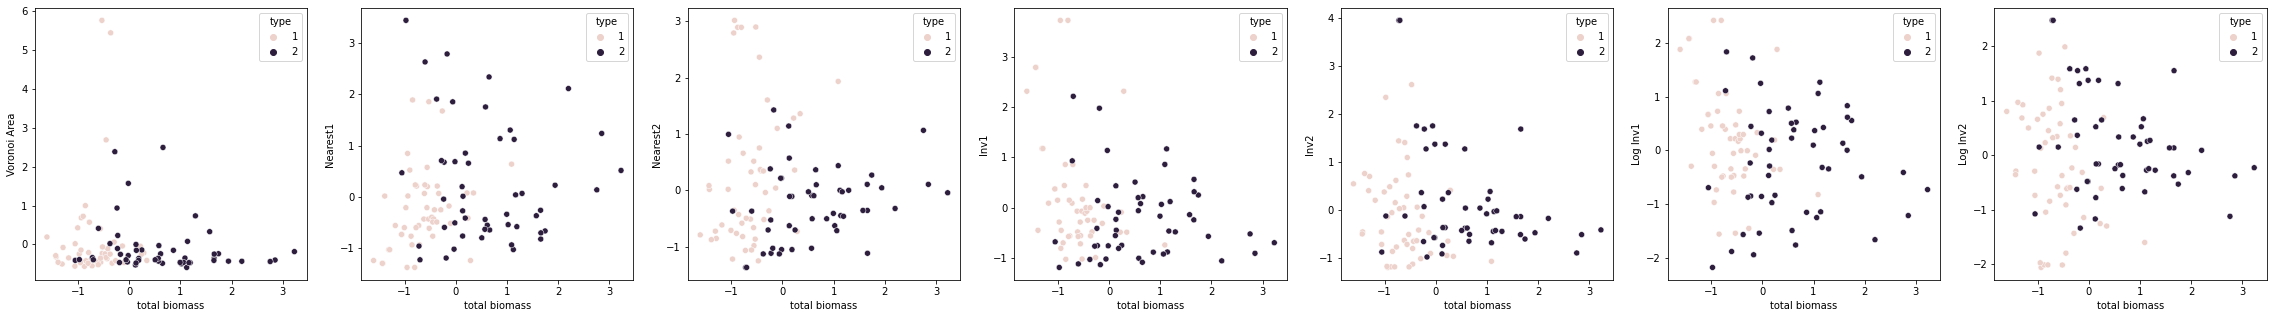

In [194]:

f, axes = plt.subplots(ncols=len(metric_list),figsize=(40,5))
for met,ax in zip(metric_list,axes.ravel()):

   sns.scatterplot(x='total biomass',y=met,hue='type',data=scaled_df,ax=ax)

In [234]:
from sklearn.model_selection import train_test_split
cols = ['Voronoi Area','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2']
y = scaled_df[scaled_df.type==2]['total biomass']
X = scaled_df[scaled_df.type==2][cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [235]:
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y,X[included]).fit()
        pvalues = model.pvalues
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [224]:
reg_mets = backward_regression(X_train, y_train, threshold_out=.05,
                           verbose=True)


Drop Nearest1                       with p-value 0.881737
Drop Log Inv1                       with p-value 0.1358
Drop Voronoi Area                   with p-value 0.0699112
Drop Inv1                           with p-value 0.062721


In [233]:
reg_mets = backward_regression(metric2[cols], metric2['total biomass'], threshold_out=.05,
                           verbose=True)

Drop Nearest2                       with p-value 0.938822
Drop Inv1                           with p-value 0.599138
Drop Voronoi Area                   with p-value 0.0946981
Drop Log Inv1                       with p-value 0.150017
Drop Nearest1                       with p-value 0.209054


In [231]:
result = sm.OLS(metric2['total biomass'],metric2[reg_mets]).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          total biomass   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.868
Method:                 Least Squares   F-statistic:                              166.0
Date:                Fri, 10 Sep 2021   Prob (F-statistic):                    2.74e-22
Time:                        17:49:30   Log-Likelihood:                         -635.19
No. Observations:                  50   AIC:                                      1274.
Df Residuals:                      48   BIC:                                      1278.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inv2          -0.4029      0.119     -3.386      0.001      -0.642      -0.164
Log Inv2    1.157e+04    991.745     11.663      0.000    9572.826    1.36e+04
==============================================================================
Omnibus:                        2.867   Durbin-Watson:                   1.248
Prob(Omnibus):                  0.238   Jarque-Bera (JB):                2.037
Skew:                           0.476   Prob(JB):                        0.361
Kurtosis:                       3.268   Cond. No.                     1.71e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

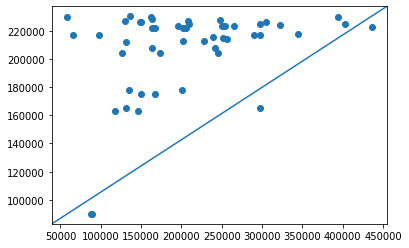

In [232]:
pred = result.predict(metric2[reg_mets])
f, ax = plt.subplots()
ax.scatter(x=metric2['total biomass'],y=pred)
ax.plot([-1,2],[-1,2], transform=ax.transAxes)

In [147]:
#RECURSIVE FEATURE ELIMINATION
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
names=pd.DataFrame(X.columns)

#use linear regression as the model
lin_reg = LinearRegression()

#This is to select 5 variables: can be changed and checked in model for accuracy
rfe_mod = RFE(lin_reg, 3, step=1) #RFECV(lin_reg, step=1, cv=5) 
myvalues=rfe_mod.fit(X,y) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

    Feature  Rank
1  Nearest1     1
2  Nearest2     1
6  Log Inv2     1


C:\Users\Jonathan\anaconda3\envs\nufeb\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


3

<AxesSubplot:xlabel='Timestep', ylabel='mother_cell'>

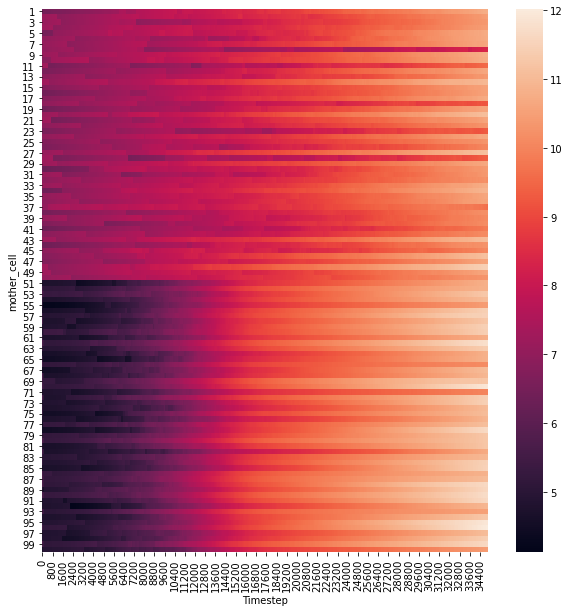

In [70]:

data = df.copy()
data['sum'] = df.groupby(['mother_cell','Timestep'])['biomass'].cumsum()
data['sum'] = np.log(data['sum'])
pivs = data.pivot_table(index='mother_cell', columns='Timestep', values='sum')
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pivs,ax=ax)


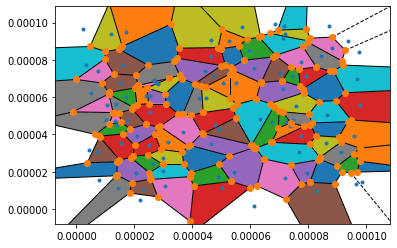

In [72]:

df = low.colonies.copy()
df = df[(df.Timestep ==0)][['x','y']]
points = df.values
vor = Voronoi(points)


#ax.plot(points[:,0], points[:,1], 'ko')
#ax.axis('equal')
ax.set_xlim(0, 1e-4)
ax.set_ylim(0, 1e-4)


#plt.show()
voronoi_plot_2d(vor)
    # colorize
for region in vor.regions:
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon))

In [73]:
areas = [abs(float(sg.Polygon(vor.vertices[vor.regions[i]]).area())) for i in range(len(vor.regions))]
areas

[5.927561114151109e-10,
 2.25029972863217e-10,
 2.0788058240223975e-09,
 0.0,
 1.152659687776903e-09,
 1.045190257839682e-10,
 2.8583516246319814e-10,
 2.1643157166143973e-10,
 6.182522249682973e-11,
 1.573275715208619e-09,
 2.1300643661018328e-10,
 3.1363831508169893e-10,
 1.4695121878969986e-10,
 1.3471068982701513e-08,
 2.6101909679608275e-10,
 5.377414661891362e-11,
 1.0002691160507039e-10,
 3.558304608420969e-08,
 1.0561295876297749e-10,
 7.885981553523601e-11,
 6.909014871963881e-11,
 4.141596684391545e-11,
 3.722982487428086e-10,
 8.46597348884112e-10,
 1.4506366243276525e-10,
 1.3790148409466636e-10,
 3.8493066470158526e-11,
 7.02232215883538e-11,
 1.3511665083535565e-10,
 8.30996234944902e-11,
 9.6644796907021e-11,
 4.98214033560005e-11,
 1.1740040295833826e-10,
 1.2471252122032506e-10,
 7.867081317005466e-11,
 4.155650114732805e-11,
 2.2312063832666177e-11,
 8.561692757853804e-11,
 7.078081081964076e-11,
 1.8371789211861683e-09,
 2.0991784903326158e-10,
 5.114900427273522e-09

In [74]:
low.colonies.loc[low.colonies.Timestep==0,'Voronoi Area'] = pd.Series(areas)

In [75]:
biomasses = low.colonies[low.colonies.Timestep==35000].groupby('mother_cell').sum().reset_index()[['mother_cell','biomass']]
biomasses.columns=['mother_cell','total biomass']

In [76]:
df = pd.merge(low.colonies,biomasses,on='mother_cell').groupby('mother_cell').max().reset_index()
df.head()

,mother_cell,Timestep,ID,type,radius,x,y,z,biomass,time,total_biomass,Colony Area,Voronoi Area,total biomass
0,1,35000,37479,1,9.851865e-07,0.000083,0.000051,0.000009,1481.991430,97.222222,123359.122311,16905.0,NaN,123359.122311
1,2,35000,37489,1,9.852460e-07,0.000093,0.000041,0.000009,1482.259767,97.222222,227208.309485,39621.0,NaN,227208.309485
2,3,35000,37524,1,9.852609e-07,0.000076,0.000082,0.000009,1482.327417,97.222222,268839.575040,47964.0,NaN,268839.575040
3,4,35000,37509,1,9.852690e-07,0.000092,0.000074,0.000009,1482.363563,97.222222,296779.902252,59144.0,NaN,296779.902252
4,5,35000,37506,1,9.852717e-07,0.000079,0.000070,0.000009,1482.375738,97.222222,265764.043668,48327.0,NaN,265764.043668


In [77]:
df2 = low.positions[low.positions.Timestep == 0]
arr = df2[['x','y','z']].to_numpy()
tree = KDTree(arr)
d, i = tree.query(arr, k=2)
d[:,1],i[:,1]
idx1 =df2.index
df2.loc[idx1,'NN']=d[:,1]
df2 = df2[['mother_cell','NN']]

C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


KeyError: "['mother_cell'] not in index"

In [ ]:
df3 = low.positions[low.positions.Timestep == 0]
arr1 = df3[df3.type==1][['x','y','z']].to_numpy()
tree1 = KDTree(arr1)
d1, i1 = tree1.query(df3[['x','y','z']].to_numpy(), k=2)
arr2 = df3[df3.type==2][['x','y','z']].to_numpy()
tree2 = KDTree(arr2)
d2, i2 = tree2.query(df3[['x','y','z']].to_numpy(), k=2)
idx1 =df3.index
n1 = list()
n2 = list()
for i in range(len(d1)):
    if d1[i,0]==0:
        n1.append(d1[i,1])
    else:
        n1.append(d1[i,0])
for i in range(len(d2)):
    if d2[i,0]==0:
        n2.append(d2[i,1])
    else:
        n2.append(d2[i,0])
df3.loc[idx1,'Nearest1']=n1
df3.loc[idx1,'Nearest2']=n2
df3 = df3[['mother_cell','Nearest1','Nearest2']]

C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Jonathan\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
inv1 = list()
for i in low.positions[low.positions.Timestep == 0][['x','y','z']].to_numpy():
    d1, i1 = tree1.query(i,k=2)
    if d1[0]==0:
        inv1.append(np.sum(1/d1[1]))
    else:
        inv1.append(np.sum(1/d1[0]))
inv2 = list()
inv3 = list()
for i in low.positions[low.positions.Timestep == 0][['x','y','z']].to_numpy():
    d2, i2 = tree2.query(i,k=2)
    if d2[0]==0:
        inv2.append(np.sum(1/d2[1]))
    else:
        inv2.append(np.sum(1/d2[0]))
    #


In [ ]:
n3 = list()
for i,j in zip(n1,n2):
    n3.append(i-j)


In [ ]:
log_inv1 = list()
for i in low.positions[low.positions.Timestep == 0][['x','y','z']].to_numpy():
    d1, i1 = tree1.query(i,k=2)
    if d1[0]==0:
        log_inv1.append(np.log(np.sum(1/(d1[1]**2))))
    else:
        log_inv1.append(np.log(np.sum(1/(d1[0]**2))))
log_inv2 = list()
for i in low.positions[low.positions.Timestep == 0][['x','y','z']].to_numpy():
    d2, i2 = tree2.query(i,k=2)
    if d2[0]==0:
        log_inv2.append(np.log(np.sum(1/(d2[1]**2))))
    else:
        log_inv2.append(np.log(np.sum(1/(d2[0]**2))))

In [ ]:
df3.loc[idx1,'Inv1']=inv1
df3.loc[idx1,'Inv2']=inv2
df3.loc[idx1,'Log Inv1']=log_inv1
df3.loc[idx1,'Log Inv2']=log_inv2
df3.loc[idx1,'Net NN']=n3

In [ ]:
df3

,mother_cell,Nearest1,Nearest2,Inv1,Inv2,Log Inv1,Log Inv2,Net NN
0,94,0.000010,0.000008,97128.586236,130130.916394,22.967582,23.552593,2.611061e-06
1,39,0.000013,0.000004,74752.843523,268811.376854,22.443885,25.003530,9.657337e-06
2,52,0.000004,0.000008,268811.376854,130130.916394,25.003530,23.552593,-3.964488e-06
3,33,0.000008,0.000009,118351.151635,109755.995542,23.362823,23.212030,-6.616876e-07
4,9,0.000008,0.000010,130929.537077,101677.064186,23.564829,23.059114,-2.197364e-06
...,...,...,...,...,...,...,...,...
95,65,0.000009,0.000011,105337.650074,94293.100188,23.129852,22.908327,-1.111948e-06
96,98,0.000008,0.000007,120237.042921,150162.846055,23.394441,23.838951,1.657468e-06
97,22,0.000008,0.000002,130590.596827,414652.289318,23.559645,25.870391,5.245860e-06
98,85,0.000008,0.000007,119910.972771,152013.431771,23.389010,23.863448,1.761154e-06


In [ ]:
df = pd.merge(df,df2,on='mother_cell').groupby('mother_cell').max().reset_index()
df = pd.merge(df,df3,on='mother_cell').groupby('mother_cell').max().reset_index()
df.head()

,mother_cell,Timestep,ID,type,radius,x,y,z,biomass,time,...,Voronoi Area,total biomass,NN,Nearest1,Nearest2,Inv1,Inv2,Log Inv1,Log Inv2,Net NN
0,1,35000,37493,1,9.852695e-07,0.000084,0.000053,0.000009,1482.366037,97.222222,...,8.184528e-11,250344.490205,0.000003,0.000007,0.000003,149962.963721,338400.271532,23.836287,25.463969,3.713233e-06
1,2,35000,37489,1,9.852502e-07,0.000096,0.000038,0.000009,1482.278816,97.222222,...,1.926363e-09,127521.965465,0.000009,0.000009,0.000011,113774.478359,95156.610473,23.283947,22.926559,-1.719674e-06
2,3,35000,37500,1,9.852609e-07,0.000079,0.000079,0.000009,1482.327417,97.222222,...,7.077862e-11,254730.268939,0.000005,0.000009,0.000005,110295.153756,211354.150258,23.221831,24.522581,4.335186e-06
3,4,35000,37509,1,9.852690e-07,0.000092,0.000071,0.000009,1482.363563,97.222222,...,2.880012e-10,260207.573994,0.000008,0.000008,0.000012,118584.254213,82749.792417,23.366758,22.647154,-3.651800e-06
4,5,35000,37506,1,9.852717e-07,0.000078,0.000074,0.000009,1482.375738,97.222222,...,4.239826e-08,282925.655142,0.000008,0.000009,0.000008,110295.153756,119419.181851,23.221831,23.380790,6.927174e-07


<AxesSubplot:xlabel='total biomass', ylabel='Net NN'>

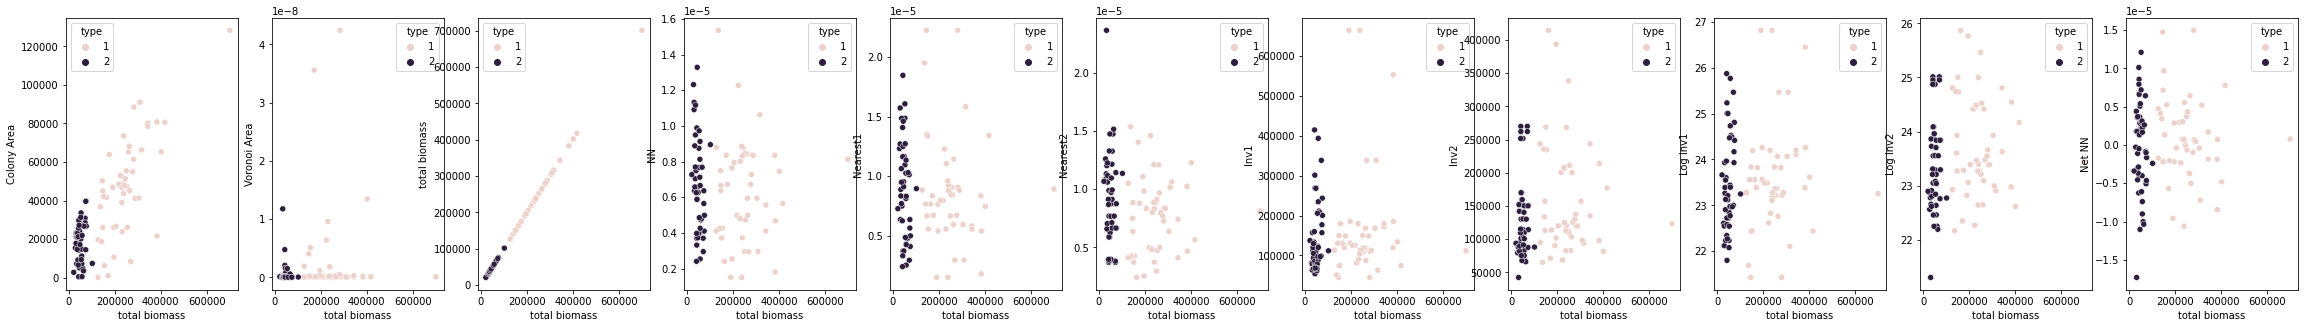

In [ ]:
f, axes = plt.subplots(ncols=11,figsize=(40,5))
sns.scatterplot(x='total biomass',y='Colony Area',hue='type',data=df,ax=axes[0])
sns.scatterplot(x='total biomass',y='Voronoi Area',hue='type',data=df,ax=axes[1])
sns.scatterplot(x='total biomass',y='total biomass',hue='type',data=df,ax=axes[2])
sns.scatterplot(x='total biomass',y='NN',hue='type',data=df,ax=axes[3])
sns.scatterplot(x='total biomass',y='Nearest1',hue='type',data=df,ax=axes[4])
sns.scatterplot(x='total biomass',y='Nearest2',hue='type',data=df,ax=axes[5])
sns.scatterplot(x='total biomass',y='Inv1',hue='type',data=df,ax=axes[6])
sns.scatterplot(x='total biomass',y='Inv2',hue='type',data=df,ax=axes[7])
sns.scatterplot(x='total biomass',y='Log Inv1',hue='type',data=df,ax=axes[8])
sns.scatterplot(x='total biomass',y='Log Inv2',hue='type',data=df,ax=axes[9])
sns.scatterplot(x='total biomass',y='Net NN',hue='type',data=df,ax=axes[10])
#for ax in axes.ravel():
   # ax.set_xscale('log')
   # ax.set_yscale('log')


In [ ]:
def lin_func(x,m,b):
    return m*x + b
from scipy import stats
for metric in ['Colony Area','Voronoi Area','total biomass','NN','Nearest1','Nearest2','Inv1','Inv2','Log Inv1','Log Inv2','Net NN']:
    x = df['total biomass']
    y = df[metric]
    res = stats.linregress(x, y)
    print(res.rvalue)
    #y_fit = lin_func(x,res.slope,res.intercept)

0.7906406216012511
0.11950566422758872
1.0
-0.08348340267164557
-0.1110621943231021
-0.1557569474528226
0.10581379749015286
0.08845034945274036
0.11075139641983651
0.12249775313424506
0.014696878103631987
